# vtt_label.ipynb
Generates a vtt closed captioning format file containing the predicted labels.

Input files are X, y, sub generated by e4_get_X_y_sub.ipynb using 1574625540_A01F11.zip which is e4 data for a walk from Old Main to Alkek and back.  The labels are all set to 'Not_Labeled' in the csv file and y ndarray
because the video has not been manually labeled

Model was created and trained using HAR_model_eval_stratification.ipynb
with DATASET == "e4_Nov2019 2s overlap" (the three e4 files with structured activities) and saved to google drive using this command running in that notebook.


    shutil.copytree('/content/my_1D_CNN_model','/content/drive/MyDrive/temp/my_1D_CNN_model')

Result can be viewed here https://mediaflo.txstate.edu/Watch/e4_794457   
In the closed caption menu turn on 'Activity Labels'


<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

[Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), Texas State University, [IMICS Lab](https://imics.wp.txstate.edu/)  

In [ ]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import time
from datetime import datetime

In [ ]:
#Helpful functions especially inside colab
from requests import get
def what_is_my_name():
    """returns the name of the running colab ipynb file"""
    #code is readily available on web - not original
    if 'google.colab' in str(get_ipython()):
        my_name = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
        my_name += ".ipynb"
    else:
        # seems a bit complicated to get filename in any environment
        # and hard coding the name here will make this not portable
        # this should elminate the failure in non-colab instances though
        my_name = 'Executing local file, not running in CoLab'
    return my_name
#start output file with unique name - important for colab runs
def start_logfiles(base_name = "unnamed", first_line = "nothing here"):
    """creates file and writes colab environment info, returns full filename
    which is concatenation of path, base_name, and current UTC time"""
    result_dir = '/content/drive/My Drive/Colab_Run_Results'
    timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime()) #UTC time
    log_fname = base_name +'_'+timestamp
    full_log_fname = result_dir+'/'+log_fname+'.txt'
    print("Starting text logfile ",full_log_fname)
    with open(full_log_fname, "w") as file_object:
        header = first_line + '\n'
        header += full_log_fname +'\n'
        header += 'Generated by ' + what_is_my_name() + '\n'
        cpu_model = !grep 'model name' /proc/cpuinfo
        header += 'CPU1: ' + cpu_model[0] + '\n'
        header += 'CPU2: ' + cpu_model[1] + '\n'
        gpu_info = !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
        header += 'GPU: ' + str(gpu_info[1]) + '\n'
        file_object.write(header)
    return full_log_fname
#Helper function since frequently checking and logging shapes
#credit https://stackoverflow.com/users/4944093/george-petrov for name method
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
def get_shapes(np_arr_list):
    """Returns text, each line is shape and dtype for numpy array in list
       example: print(get_shapes([X_train, X_test, y_train, y_test]))"""
    shapes = ""
    for i in np_arr_list:
        my_name = namestr(i,globals())
        shapes += (my_name[0] + " shape is " + str(i.shape) \
            + " data type is " + str(i.dtype) + "\n")
    return shapes

In [ ]:
input_dir = '/content/drive/MyDrive/Processed_Datasets/e4_Nov2019_xys/free_walk_not_labeled'
# This is where the e4_get_X_y_sub.ipynb output files are stored using 1574625540_A01F11.zip
X = np.load(input_dir + '/' + 'X.npy')
y = np.load(input_dir + '/' +'y.npy')
sub= np.load(input_dir + '/' +'sub.npy')

log_info = 'arrays loaded from'
log_info += input_dir + '\n'
shapes = get_shapes([X,y,sub])
print (log_info,"Starting shape of loaded files")
print(shapes)

# Drop component acceleration
log_info += "Using total component accel, deleting accel_x/y/z from X\n"
X = np.delete(X, [0,1,2],2) # delete columns 1-3 along axis 2
#print(get_shapes([X,y,sub]))

#One-Hot-Encode y...there must be a better way when starting with strings
#https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

if (y.shape[1]==1):
    # integer encode
    y_vector = np.ravel(y) #encoder won't take column vector
    le = LabelEncoder()
    integer_encoded = le.fit_transform(y_vector) #convert from string to int
    name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print("One-hot-encoding: category names -> int -> one-hot")
    print(name_mapping) # seems risky as interim step before one-hot
    log_info += "One Hot:" + str(name_mapping) +"\n\n"
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    print("One-hot-encoding",onehot_encoder.categories_)
    y=onehot_encoded
else:
    print ("y.shape[1] is not one, appears to be encoded already. Skipping")

print("\n"+"Final shapes\n"+get_shapes([X,y,sub]))

arrays loaded from/content/drive/MyDrive/Processed_Datasets/e4_Nov2019_xys/free_walk_not_labeled
 Starting shape of loaded files
X shape is (665, 96, 4) data type is float64
y shape is (665, 1) data type is <U11
sub shape is (665, 1) data type is int64

One-hot-encoding: category names -> int -> one-hot
{'Not_Labeled': 0}
One-hot-encoding [array([0])]

Final shapes
X shape is (665, 96, 1) data type is float64
y shape is (665, 1) data type is float64
sub shape is (665, 1) data type is int64



In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/temp/my_1D_CNN_model')
predictions = model.predict(X, verbose=0,batch_size=32)
#must use values not one-hot encoding, use argmax to convert
y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis

[2 2 5 5 5]


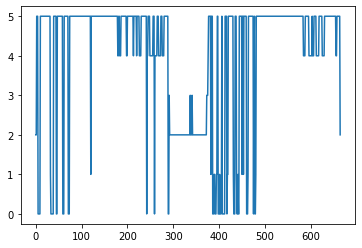

In [ ]:
print(y_pred[:5])
plt.plot(y_pred)

In [ ]:
# the one-hot encoding of the y here is meaningless since all labels are 'Not_Labeled'
# using output from train encoding, flip dictionary, use to build string version
# One-hot-encoding: category names -> int -> one-hot
str_to_key_dict = {'Downstairs': 0, 'Jogging': 1, 'Sitting': 2, 'Standing': 3, 'Upstairs': 4, 'Walking': 5}
key_to_str_dict = dict([(value, key) for key, value in str_to_key_dict.items()])
print(key_to_str_dict)
y_pred_labels = np.vectorize(key_to_str_dict.get)(y_pred)
unique, counts = np.unique(y_pred_labels, return_counts=True)
print("Final Label Counts")
print (np.asarray((unique, counts)).T)

{0: 'Downstairs', 1: 'Jogging', 2: 'Sitting', 3: 'Standing', 4: 'Upstairs', 5: 'Walking'}
Final Label Counts
[['Downstairs' '55']
 ['Jogging' '18']
 ['Sitting' '82']
 ['Standing' '6']
 ['Upstairs' '65']
 ['Walking' '439']]


# Build vtt file
Example format from the beginning of recorded and captioned video<pre>
WEBVTT

1
00:00:03.840 --> 00:00:13.920
Lee Hinkle: Alright Suzy a quick rundown of some work i've been doing on load data time series, and specifically for this particular session i'm going to talk about.

2
00:00:14.490 --> 00:00:23.550
Lee Hinkle: Work on doing with the E4 wristband and so first off, let me kind of ground, you know and the load data time to us and the idea behind this is.
</pre>

In [ ]:
START_SECS = 9 # this is the number of seconds of video before 1st label
STEP_SECS = 1 # this is the number of seconds until the next sample is evaluated
my_labels_vtt = 'WEBVTT\n\n' # header
my_labels_vtt += '1\n' # put in first line before labels
my_labels_vtt += '00:00:05.000 --> 00:00:10.000\n'
my_labels_vtt += 'activities shown are predictions by the trained model\n\n'

num_rows = np.shape(y_pred_labels)[0]
for i in range(2,num_rows):
    start = datetime.fromtimestamp(START_SECS + i*STEP_SECS)
    end = datetime.fromtimestamp(START_SECS+((i+1)*STEP_SECS))
    my_labels_vtt += str(i) + "\n"
    my_labels_vtt += start.strftime("%H:%M:%S.000")
    #my_labels_vtt += (time.strftime("%H:%M:%S.000", time.gmtime(START_TIME+i*STEP_SECS)))
    my_labels_vtt += " --> "
    my_labels_vtt += end.strftime("%H:%M:%S.000")
    #my_labels_vtt += (time.strftime("%H:%M:%S.000", time.gmtime(START_TIME+((i+1)*STEP_SECS))))
    my_labels_vtt += "\n"
    my_labels_vtt += y_pred_labels[i] + "\n\n"
#print(my_labels_vtt) # pretty long and makes scrolling a pain, should make 'head' type call

WEBVTT

1
00:00:05.000 --> 00:00:10.000
activities shown are predictions by the trained model

2
00:00:11.000 --> 00:00:12.000
Walking

3
00:00:12.000 --> 00:00:13.000
Walking

4
00:00:13.000 --> 00:00:14.000
Walking

5
00:00:14.000 --> 00:00:15.000
Downstairs

6
00:00:15.000 --> 00:00:16.000
Downstairs

7
00:00:16.000 --> 00:00:17.000
Downstairs

8
00:00:17.000 --> 00:00:18.000
Downstairs

9
00:00:18.000 --> 00:00:19.000
Downstairs

10
00:00:19.000 --> 00:00:20.000
Walking

11
00:00:20.000 --> 00:00:21.000
Walking

12
00:00:21.000 --> 00:00:22.000
Walking

13
00:00:22.000 --> 00:00:23.000
Walking

14
00:00:23.000 --> 00:00:24.000
Walking

15
00:00:24.000 --> 00:00:25.000
Walking

16
00:00:25.000 --> 00:00:26.000
Walking

17
00:00:26.000 --> 00:00:27.000
Walking

18
00:00:27.000 --> 00:00:28.000
Walking

19
00:00:28.000 --> 00:00:29.000
Walking

20
00:00:29.000 --> 00:00:30.000
Walking

21
00:00:30.000 --> 00:00:31.000
Walking

22
00:00:31.000 --> 00:00:32.000
Walking

23
00:00:32.000 

In [ ]:
text_file = open("/content/drive/MyDrive/temp/labels.vtt", "w")
n = text_file.write(my_labels_vtt)
text_file.close()